In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 3s (98.5 kB/s)
Reading package l

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!wget https://jdbc.postgresql.org/download/postgresql-42.3.6.jar

--2022-05-29 21:23:53--  https://jdbc.postgresql.org/download/postgresql-42.3.6.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1041072 (1017K) [application/java-archive]
Saving to: ‘postgresql-42.3.6.jar.1’

postgresql-42.3.6.j 100%[===================>]   1017K  6.23MB/s    in 0.2s    

2022-05-29 21:23:53 (6.23 MB/s) - ‘postgresql-42.3.6.jar.1’ saved [1041072/1041072]



In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("M16-Amazon-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.3.6.jar").getOrCreate()

In [5]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("amazon_reviews_us_Furniture_v1_00.tsv.gz"), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   24509695|R3VR960AHLFKDV|B004HB5E0E|     488241329|Shoal Creek Compu...|       Furniture|          4|            0|          0|   N|                Y|... desk is very ...|This desk is very...| 2015-08-31|
|         US|   34731776|R16LGVMFKIUT0G|B0042TNMMS|     205864445|Dorel Home Produc...|       Furniture|          5|    

In [6]:
# check df for data types
df

DataFrame[marketplace: string, customer_id: int, review_id: string, product_id: string, product_parent: int, product_title: string, product_category: string, star_rating: int, helpful_votes: int, total_votes: int, vine: string, verified_purchase: string, review_headline: string, review_body: string, review_date: string]

In [7]:
# Filter df total_votes for greater than or equal to 20
totalvotes_df = df.filter("total_votes>=20")
totalvotes_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   41681546| RL8D0KJ0J9L0O|B00BWC1X3S|     328960153|Zinus 14 Inch Eli...|       Furniture|          5|          152|        165|   N|                Y|A solid VICTORY f...|I've been looking...| 2015-08-31|
|         US|   16806846|R1BEINAIQFBRJC|B007I81A60|      68465765|8" Night Therapy ...|       Furniture|          5|    

In [8]:
#Filter the new df created above and creates a new df to retrieve all the rows where the number of helpful_votes divided by total_votes is equal to or greater than 50%.
helpful_v_50_df = totalvotes_df.filter("helpful_votes/total_votes>=0.5")
helpful_v_50_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   41681546| RL8D0KJ0J9L0O|B00BWC1X3S|     328960153|Zinus 14 Inch Eli...|       Furniture|          5|          152|        165|   N|                Y|A solid VICTORY f...|I've been looking...| 2015-08-31|
|         US|   16806846|R1BEINAIQFBRJC|B007I81A60|      68465765|8" Night Therapy ...|       Furniture|          5|    

In [9]:
# print count
print(helpful_v_50_df.count())

18155


In [10]:
Total_Helpfull_reviews = helpful_v_50_df.count()

In [11]:
#Filter the df created above and creates a new df or table that retrieves all the rows where a review was written as part of the Vine program and was paid
vine_review_df = helpful_v_50_df.filter(helpful_v_50_df["vine"] == "Y")
vine_review_df_paid = vine_review_df.filter(vine_review_df["verified_purchase"] == "Y")
vine_review_df_nonPaid = vine_review_df.filter(vine_review_df["verified_purchase"] == "N")


In [12]:
# Retrieve all the rows where the review was not part of the Vine program not paid, vine == 'N' and verified_purchase == "N"
nonvine_review_df = helpful_v_50_df.filter(helpful_v_50_df["vine"] == "N")
nonvine_review_df_paid = nonvine_review_df.filter(nonvine_review_df["verified_purchase"] == "Y")
nonvine_review_df_nonPaid = nonvine_review_df.filter(nonvine_review_df["verified_purchase"] == "N")


In [13]:
from pyspark.sql.functions import count

#Total Number of reviews

print("Total Number of Helpful Vine and Non Vine Reviews Paid and Not Paid: %.0f" % Total_Helpfull_reviews)

# Total number of reviews for each dataframe:
# Vine Paid
vine_review_paid_count = vine_review_df_paid.count()
print("Total Number of Helpful Vine Reviews Paid: %.0f" % vine_review_paid_count)

# Vine Not Paid
vine_review_nonPaid_count = vine_review_df_nonPaid.count()
print("Total Number of Helpful Vine Reviews Not Paid: %.0f" % vine_review_nonPaid_count)

# Not Vine Paid
nonvine_review_paid_count = nonvine_review_df_paid.count()
print("Total Number of Helpful Non Vine Reviews Paid: %.0f" % nonvine_review_paid_count)

# not Vine Not Paid
nonvine_review_nonPaid_count = nonvine_review_df_nonPaid.count()
print("Total Number of Helpful Non Vine Reviews Not Paid: %.0f" % nonvine_review_nonPaid_count)


Total Number of Helpful Vine and Non Vine Reviews Paid and Not Paid: 18155
Total Number of Helpful Vine Reviews Paid: 3
Total Number of Helpful Vine Reviews Not Paid: 133
Total Number of Helpful Non Vine Reviews Paid: 15080
Total Number of Helpful Non Vine Reviews Not Paid: 2939


In [14]:
# Number of Five Star Reviews for above Vine and Non Vine Paid and Not Paid dataframes
from pyspark.sql.functions import round, col

fivestars_all_df = helpful_v_50_df.filter(helpful_v_50_df["star_rating"]=="5")
print("Total Number of Helpful Five Star Reviews: %.0f" % fivestars_all_df.count())

fivestars_vine_paid_df = vine_review_df_paid.filter(vine_review_df_paid["star_rating"]=="5")
print("Total Number of Helpful Five Star Vine Reviews Paid: %.0f" % fivestars_vine_paid_df.count())

fivestars_vine_nonPaid_df = vine_review_df_nonPaid.filter(vine_review_df_nonPaid["star_rating"]=="5")
print("Total Number of Helpful Five Star Vine Reviews Not Paid: %.0f" % fivestars_vine_nonPaid_df.count())

fivestars_nonvine_paid_df = nonvine_review_df_paid.filter(nonvine_review_df_paid["star_rating"]=="5")
print("Total Number of Helpful Five Star Non-Vine Reviews Paid: %.0f" % fivestars_nonvine_paid_df.count())

fivestars_nonvine_nonPaid_df = nonvine_review_df_nonPaid.filter(nonvine_review_df_nonPaid["star_rating"]=="5")
print("Total Number of Helpful Five Star Non_Vine Reviews Not Paid: %.0f" % fivestars_nonvine_nonPaid_df.count())
 

Total Number of Helpful Five Star Reviews: 8556
Total Number of Helpful Five Star Vine Reviews Paid: 2
Total Number of Helpful Five Star Vine Reviews Not Paid: 72
Total Number of Helpful Five Star Non-Vine Reviews Paid: 7323
Total Number of Helpful Five Star Non_Vine Reviews Not Paid: 1159


In [15]:
# Percentage of five star Reviews for above Paid and Not Paid dataframes
fivestars_vine_paid_pct = (fivestars_vine_paid_df.count()/vine_review_paid_count)*100
print("Percent of Five Star Vine Reviews Paid: %.0f" % fivestars_vine_paid_pct)

fivestars_vine_nonPaid_pct = (fivestars_vine_nonPaid_df.count()/vine_review_nonPaid_count)*100
print("Percent of Five Star Vine Reviews Not Paid: %.0f" % fivestars_vine_nonPaid_pct)

fivestars_nonvine_paid_pct = (fivestars_nonvine_paid_df.count()/nonvine_review_paid_count)*100
print("Percent of Five Star Vine Reviews Paid: %.0f" % fivestars_nonvine_paid_pct)

fivestars_nonvine_nonPaid_pct = (fivestars_nonvine_nonPaid_df.count()/nonvine_review_nonPaid_count)*100
print("Percent of Five Star Vine Reviews Not Paid: %.0f" % fivestars_nonvine_nonPaid_pct)



Percent of Five Star Vine Reviews Paid: 67
Percent of Five Star Vine Reviews Not Paid: 54
Percent of Five Star Vine Reviews Paid: 49
Percent of Five Star Vine Reviews Not Paid: 39


In [16]:
# Total number of reviews
total_reviews_count = df.count()
print("Total Number of Reviews: %.0f" % total_reviews_count)

Total_Helpfull_reviews = helpful_v_50_df.count()
print("Total Number of 'Helpful' Reviews: %.0f" % Total_Helpfull_reviews)

Total Number of Reviews: 792113
Total Number of 'Helpful' Reviews: 18155


In [17]:
#Total number of All Five Star reviews
fivestars_df = df.filter(df["star_rating"] == '5')
fivestars_df.show()

fivestars_count = fivestars_df.count()
print("Total Number of Five Star Reviews: %.0f" % fivestars_count)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   34731776|R16LGVMFKIUT0G|B0042TNMMS|     205864445|Dorel Home Produc...|       Furniture|          5|            0|          0|   N|                Y|          Five Stars|          Great item| 2015-08-31|
|         US|    1272331|R1AIMEEPYHMOE4|B0030MPBZ4|     124663823|Bathroom Vanity T...|       Furniture|          5|    

In [24]:
#Dataframe of Vine and Non Vine Reviews
import pandas as pd
Total_Num_Reviews_H = pd.DataFrame({
               "Vine Paid": vine_review_paid_count,
               "Vine Not Paid": vine_review_nonPaid_count,
               "Not Vine Paid": nonvine_review_paid_count,
               "Not Vine Not Paid": nonvine_review_nonPaid_count,
               "Total Helpful Reviews": Total_Helpfull_reviews}, index=[0])

Total_Num_Reviews_H

,Vine Paid,Vine Not Paid,Not Vine Paid,Not Vine Not Paid,Total Helpful Reviews
0,3,133,15080,2939,18155


In [26]:
Total_Num_Reviews_HS = Total_Num_Reviews_H.astype(float)

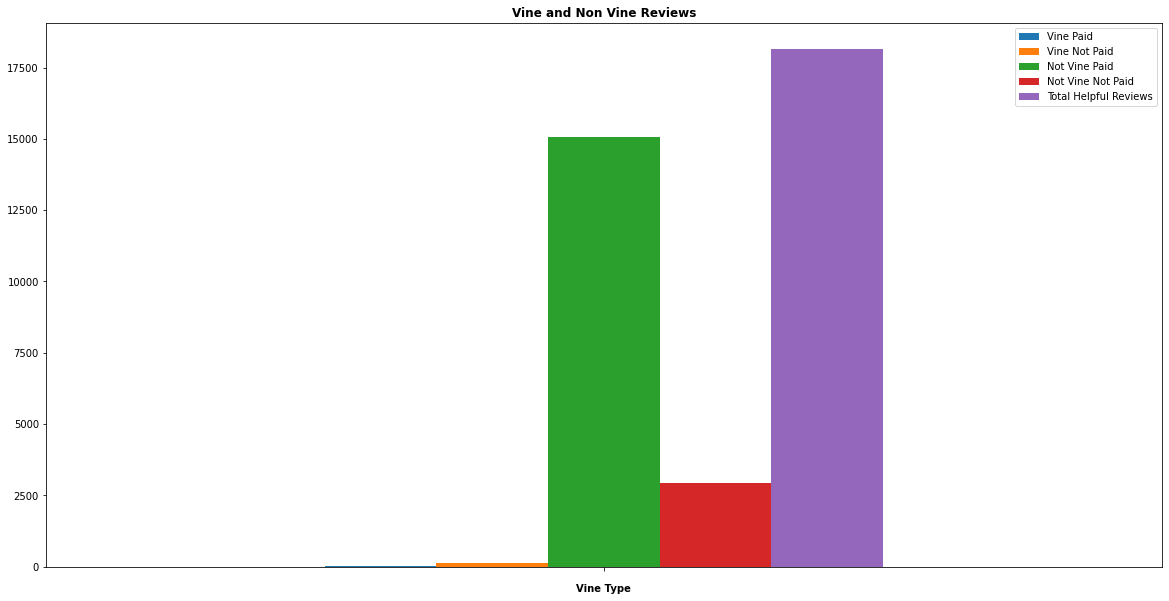

<Figure size 432x288 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
Total_Num_Reviews_HS.plot(kind="bar", figsize=(20,10))

# Set a title for the chart
plt.title("Vine and Non Vine Reviews", fontweight='bold')
plt.xlabel("Vine Type", fontweight='bold')
plt.xticks(color='w')

plt.show()
plt.tight_layout()
plt.savefig("Vine and Non Vine Reviews.png")

In [31]:
#Formated Dataframe of Vine and Non Vine Reviews

Total_Num_Reviews_H["Vine Paid"] = Total_Num_Reviews_H["Vine Paid"].map("{:,}".format)

Total_Num_Reviews_H["Vine Not Paid"] = Total_Num_Reviews_H["Vine Not Paid"].map("{:,}".format)

Total_Num_Reviews_H["Not Vine Paid"] = Total_Num_Reviews_H["Not Vine Paid"].map("{:,}".format)

Total_Num_Reviews_H["Not Vine Not Paid"] = Total_Num_Reviews_H["Not Vine Not Paid"].map("{:,}".format)

Total_Num_Reviews_H["Total Helpful Reviews"] = Total_Num_Reviews_H["Total Helpful Reviews"].map("{:,}".format)

Total_Num_Reviews_H


,Vine Paid,Vine Not Paid,Not Vine Paid,Not Vine Not Paid,Total Helpful Reviews
0,3,133,"15,080","2,939","18,155"


In [48]:
#Dataframe of Percentage of Five Star Vine and Non Vine Reviews
import pandas as pd
Total_Num_FIVEs_Reviews_H = pd.DataFrame({
               "Vine Paid Five Star Reviews": fivestars_vine_paid_pct,
               "Vine Not Paid Five Star Reviews": fivestars_vine_nonPaid_pct,
               "Not Vine Paid Five Star Reviews": fivestars_nonvine_paid_pct,
               "Not Vine Not Paid Five Star Reviews": fivestars_nonvine_nonPaid_pct}, index=[0])


In [49]:
Total_Num_FIVEs_Reviews_HS = Total_Num_FIVEs_Reviews_H.astype(float)
Total_Num_FIVEs_Reviews_HS

,Vine Paid Five Star Reviews,Vine Not Paid Five Star Reviews,Not Vine Paid Five Star Reviews,Not Vine Not Paid Five Star Reviews
0,66.666667,54.135338,48.561008,39.435182


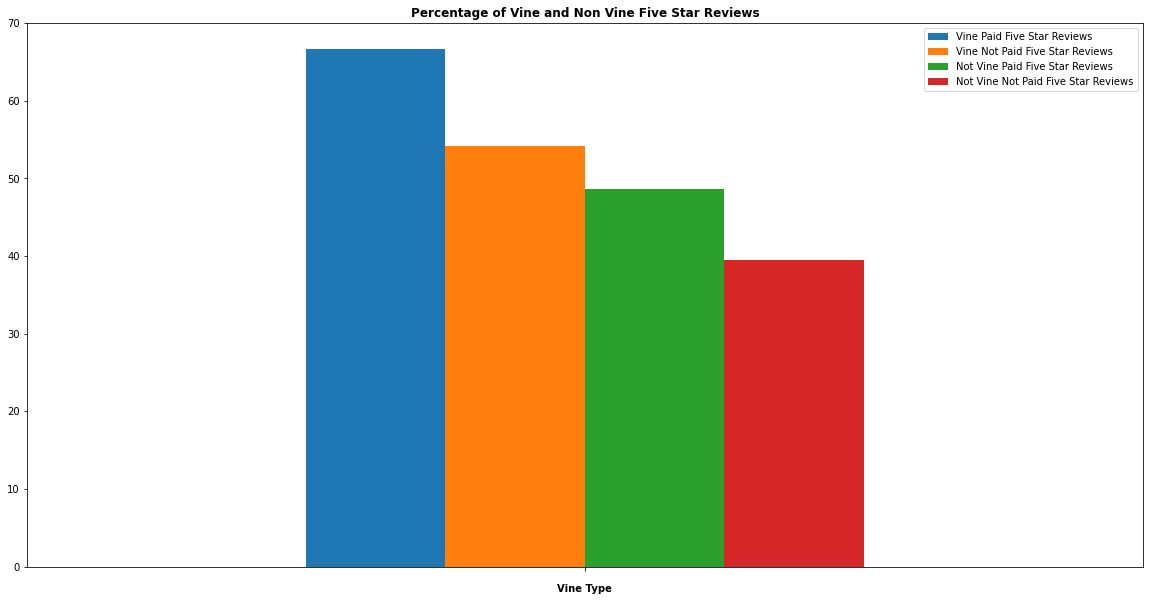

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
Total_Num_FIVEs_Reviews_HS.plot(kind="bar", figsize=(20,10))

# Set a title for the chart
plt.title("Percentage of Vine and Non Vine Five Star Reviews", fontweight='bold')
plt.xlabel("Vine Type", fontweight='bold')
plt.xticks(color='w')


plt.show()
plt.tight_layout()

In [51]:
#Dataframe of Percentage of Five Star Vine and Non Vine Reviews


Total_Num_FIVEs_Reviews_H["Vine Paid Five Star Reviews"] = Total_Num_FIVEs_Reviews_H["Vine Paid Five Star Reviews"].map("{:.0f}".format)

Total_Num_FIVEs_Reviews_H["Vine Not Paid Five Star Reviews"] = Total_Num_FIVEs_Reviews_H["Vine Not Paid Five Star Reviews"].map("{:.0f}".format)

Total_Num_FIVEs_Reviews_H["Not Vine Paid Five Star Reviews"] = Total_Num_FIVEs_Reviews_H["Not Vine Paid Five Star Reviews"].map("{:.0f}".format)

Total_Num_FIVEs_Reviews_H["Not Vine Not Paid Five Star Reviews"] = Total_Num_FIVEs_Reviews_H["Not Vine Not Paid Five Star Reviews"].map("{:.0f}".format)


Total_Num_FIVEs_Reviews_H

,Vine Paid Five Star Reviews,Vine Not Paid Five Star Reviews,Not Vine Paid Five Star Reviews,Not Vine Not Paid Five Star Reviews
0,67,54,49,39
